In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import camb
import astropy.units as u
import scipy
import scipy.optimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import figure

In [3]:
filename = 'COM_CompMap_CMB-smica_2048_R1.20.fits' #CMB map smica
mask_path = 'COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits' #Common mask
m = hp.read_map(filename)

#computing powerspectrum through spherical harmonic transformation
clT = hp.sphtfunc.anafast(m)

#apply mask
mask = hp.read_map(mask_path)
map_masked = hp.ma(m)
map_masked.mask = np.logical_not(mask)

**depiction of different curvatures on power spectrum using CAMB**

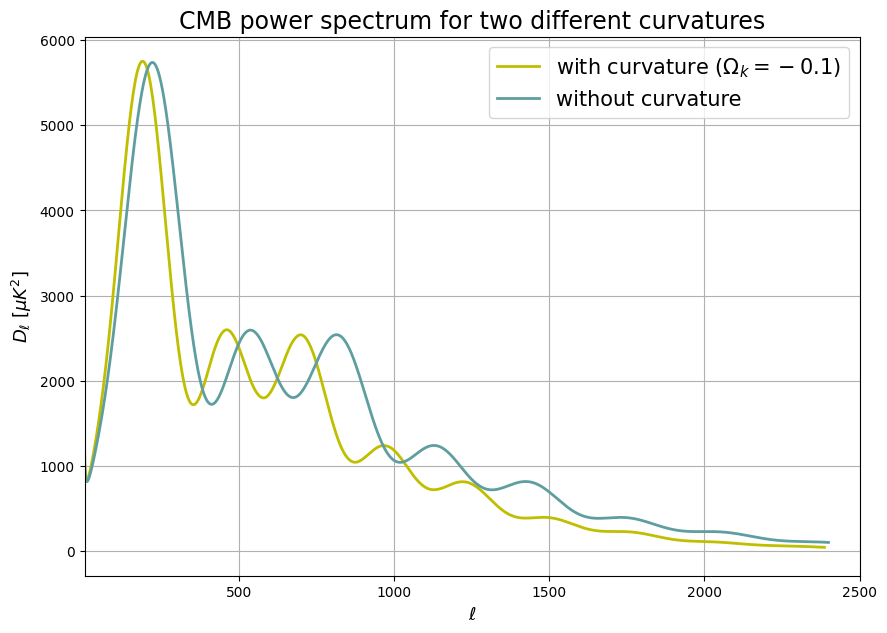

In [4]:
#get powerspectrum using camb
#input parameters stem from Planck release 2018 (TT,TE,EE+lowE+lensing+BAO)
def get_powerspectrum(omega_k):
    parameters = camb.CAMBparams()
    parameters.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933, mnu=0.0, tau=0.0561, omk=omega_k)
    parameters.InitPower.set_params(As=np.exp(3.047)/1e10, ns=0.9665, r=0)
    results = camb.get_results(parameters)

    powers = results.get_cmb_power_spectra(parameters, CMB_unit='muK')
    total_cl = powers['lensed_scalar']
    ell = np.arange(total_cl.shape[0])

    return ell, total_cl

#set parameters for a spherical universe
ell1, total_cl1 = get_powerspectrum(-0.1)

#set parameters for a flat universe
ell2, total_cl2 = get_powerspectrum(0)

#plot
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(ell1, total_cl1[:, 0], color = 'y', label = "with curvature ($\Omega_k = -0.1$)", linewidth=2)
plt.plot(ell2, total_cl2[:, 0], color = 'cadetblue', label = "without curvature", linewidth=2)
plt.xlabel('$\ell$', fontsize=13)
plt.ylabel('$D_\ell \ [\mu K^2]$', fontsize=13)
plt.title('CMB power spectrum for two different curvatures', fontsize=17)
plt.xlim([2, 2500])
plt.grid()
plt.legend(fontsize=15)
plt.show()

**Simulated CMB map** (function taken from CMB_Analysis_Summer_School by Jeff McMahon and Renée Hložek)

/tmp/ipykernel_172/4678867.py:20: RuntimeWarning: invalid value encountered in divide
  ClTT = DlTT[:, 0] * 2 * np.pi / (ell*(ell+1))


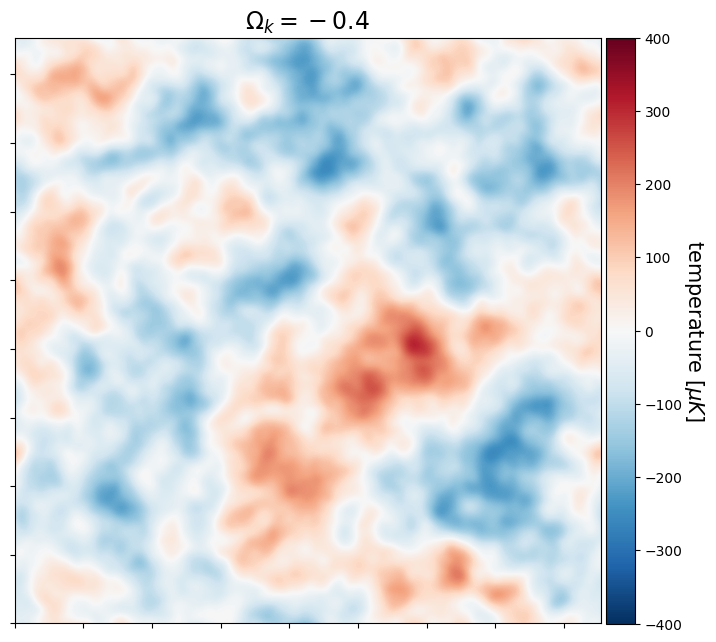

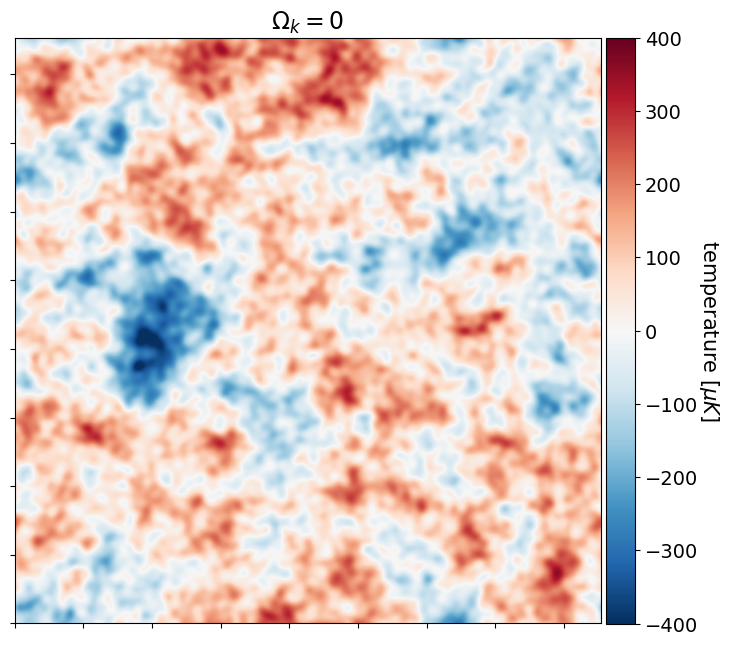

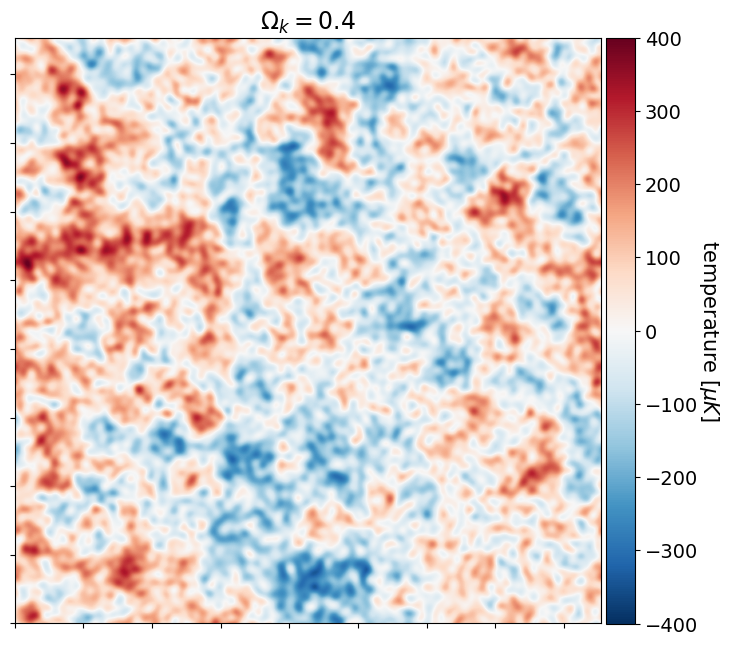

In [5]:
#creating (flat, spherical, hyperbolic) spectra with more extreme curvatures
simul = [-0.4, 0, 0.4]

## variables to set up the size of the map
N = int(2**10)  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs this should be a factor of 2^N
pix_size  = 0.5 # size of a pixel in arcminutes

## variables to set up the map plots
c_min = int(-400)  # minimum for color bar
c_max = int(400)   # maximum for color bar
X_width = N*pix_size/60  # horizontal map width in degrees
Y_width = N*pix_size/60 # vertical map width in degrees


def make_CMB_T_map(N,pix_size,ell,DlTT):
    "makes a realization of a simulated CMB sky map"

    # convert Dl to Cl
    ClTT = DlTT[:, 0] * 2 * np.pi / (ell*(ell+1))
    ClTT[0] = 0
    ClTT[1] = 0

    # make a 2d coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+0.5 - N/2) /(N-1)
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2 + Y**2)
    
    # now make a 2d CMB power spectrum
    ell_scale_factor = 2 * np.pi / (pix_size/60 * np.pi/180)
    ell2d = R * ell_scale_factor
    ClTT_expanded = np.zeros(int(ell2d.max())+1)
    ClTT_expanded[0:(ClTT.size)] = ClTT
    CLTT2d = ClTT_expanded[ell2d.astype(int)]
    ## make a plot of the 2d cmb power spectrum, note the x and y axis labels need to be fixed
    #Plot_CMB_Map(CLTT2d**2. *ell2d * (ell2d+1)/2/np.pi,0,np.max(CLTT2d**2. *ell2d * (ell2d+1)/2/np.pi)/10.,ell2d.max(),ell2d.max())  ###
 
    # now make a realization of the CMB with the given power spectrum in fourier space
    ramdomn_array_for_T = np.fft.fft2(np.random.normal(0,1,(N,N)))    
    FT_2d = np.sqrt(np.sqrt(CLTT2d**2)) * ramdomn_array_for_T
    ## make a plot of the 2d cmb simulated map in fourier space, note the x and y axis labels need to be fixed
    #Plot_CMB_Map(np.real(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),0,np.max(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),ell2d.max(),ell2d.max())  ###
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) /(pix_size /60* np.pi/180)
    CMB_T = np.real(CMB_T)

    ## return the map
    return(CMB_T)
  ###############################

for i in simul:

    def Plot_CMB_Map(Map_to_Plot,c_min,c_max,X_width,Y_width):
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        #print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
        plt.figure(figsize=(8,8))
        plt.title(f"$\Omega_k = {i}$", fontsize = 17)
        im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
        im.set_clim(c_min,c_max)
        ax=plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
    
        cbar = plt.colorbar(im, cax=cax)
        #cbar = plt.colorbar()
        im.set_extent([0,X_width,0,Y_width])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.rcParams['xtick.labelsize'] = 14
        plt.rcParams['ytick.labelsize'] = 14
        cbar.set_label('temperature $[\mu K]$', rotation=270, fontsize = 15, labelpad=17)
        plt.show()
        return(0)
  ###############################

    ell, total_cl = get_powerspectrum(i)
    CMB_T = make_CMB_T_map(N,pix_size,ell,total_cl)
    p = Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width)

**Applying mask, performing first order correction and comparing data to CAMB**

In [6]:
#get power spectrum of masked CMB and compute the sky fraction that is left
clT_masked = hp.anafast(map_masked, lmax=2400, use_pixel_weights=True)
sky_fraction = len(map_masked.compressed()) / len(map_masked)
clT_masked_lim = clT_masked[:2401]

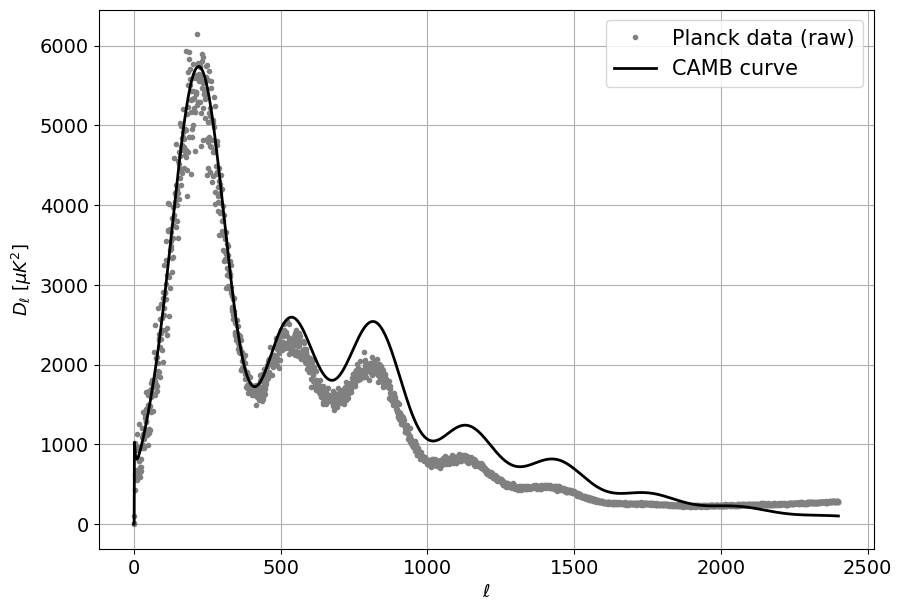

In [7]:
#plot power spectrum of masked cmb map and camb curve of flat universe
plt.plot(ell2,ell2*(ell2+1)*clT_masked_lim/(2*np.pi)/sky_fraction,'.', color='gray', label='Planck data (raw)')
plt.plot(ell2, total_cl2[:, 0], color='k', label='CAMB curve', linewidth=2)
plt.xlabel('$\ell$', fontsize=13)
plt.ylabel('$D_\ell \ [\mu K^2]$', fontsize=13)
#plt.title('CMB power spectrum')
plt.grid()
plt.legend(fontsize=15)
plt.show()

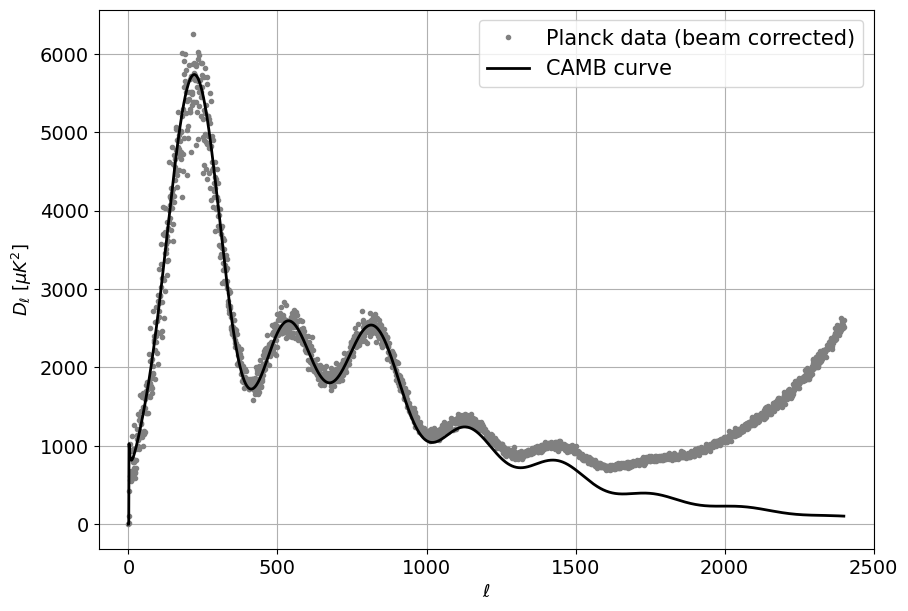

In [8]:
#first order correction using only healpy
w_ell = hp.gauss_beam((5*u.arcmin).to_value(u.radian), lmax=2400)

#figure(figsize=(8, 6), dpi=80)
plt.plot(ell2,ell2*(ell2+1)*clT_masked_lim/(2*np.pi)/sky_fraction / w_ell**2,'.', color='gray', label='Planck data (beam corrected)')
plt.plot(ell2, total_cl2[:, 0], color='black', label='CAMB curve', linewidth=2)
plt.xlabel(r'$\ell$', fontsize=13)
plt.ylabel(r'$D_\ell~[\mu K^2]$', fontsize=13)
plt.grid()
plt.legend(loc='best', fontsize=15)
plt.xlim(-100,2500)
plt.show()

**what will be used:**

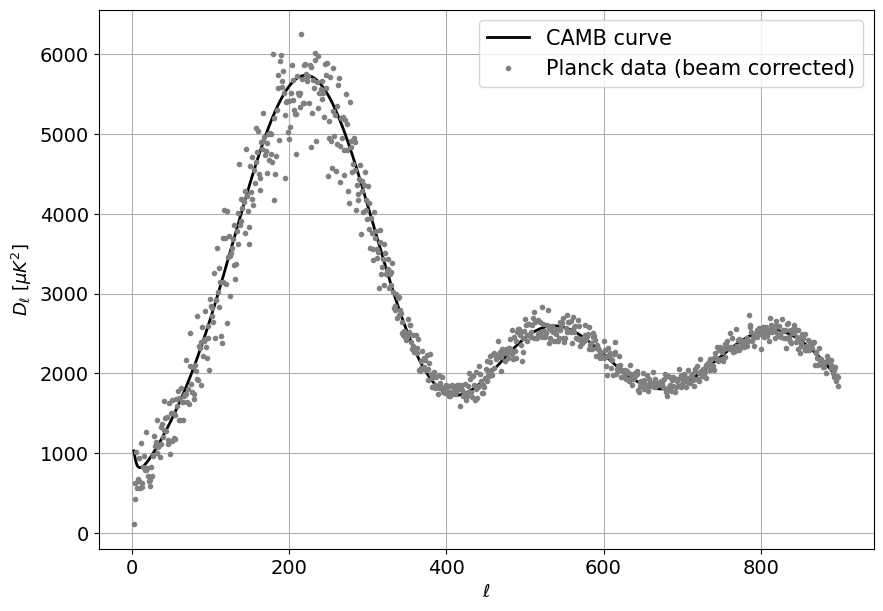

In [9]:
#omit data at high-ell since correction is of first order
w_ell = w_ell[2:900]
ell = ell2[2:900]
dl = total_cl2[2:900, 0]
clT_masked_lim_new = clT_masked_lim[2:900]

#figure(figsize=(8, 6), dpi=80)
plt.plot(ell, dl, color='black', label='CAMB curve',linewidth=2)
plt.plot(ell,ell*(ell+1)*clT_masked_lim_new/(2*np.pi)/sky_fraction / w_ell**2,'.', color='gray', label='Planck data (beam corrected)')
plt.xlabel(r'$\ell$', fontsize=13)
plt.ylabel(r'$D_\ell~[\mu K^2]$', fontsize=13)
plt.grid()
plt.legend(loc='best', fontsize=15)
plt.show()

**Neg_log_likelihood 1D search**

In [10]:
#cosmic variance
variance = 2 / ((2*ell+1)*sky_fraction)

In [64]:
#maximum likelihood estimation, varying only omega_k
def neg_log_likelihood1(steps):

    data = np.linspace(-0.1,0.1,steps) # range of Omega_k
    result = []

    for i in data:
        parameters = camb.CAMBparams() 
        parameters.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933, mnu=0.0, tau=0.0561, omk=i)
        parameters.InitPower.set_params(As=np.exp(3.047)/1e10, ns=0.9665, r=0)
        results = camb.get_results(parameters)
    
        powers = results.get_cmb_power_spectra(parameters, CMB_unit='muK')
        total_dl = powers['lensed_scalar']
        ell = np.arange(total_dl.shape[0])
        ell = ell[0:900]
        dl = total_dl[0:900, 0] # CAMB
        clt = clT_masked_lim[0:900] # Data
        
        w_ell = hp.gauss_beam((5*u.arcmin).to_value(u.radian), lmax=899) # beam window function
        
        planck = ell,ell*(ell+1)*clt/(2*np.pi) / w_ell**2 /sky_fraction # D_l of data, deconvoluted
    
        distance = np.sum((planck[1][2:900] - dl[2:900])** 2/variance) # computing value proportional to neg_log_likelihood
        result.append(distance)

    #plt.plot(data, results, '.')
    #plt.show()
        
    return result

result = neg_log_likelihood1(100)

#to use with scipy.optimize.minimize
def neg_log_likelihood1_( omegak, *args ):

    parameters = camb.CAMBparams() 
    parameters.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933, mnu=0.0, tau=0.0561, omk=omegak)
    parameters.InitPower.set_params(As=np.exp(3.047)/1e10, ns=0.9665, r=0)
    results = camb.get_results(parameters)
    
    powers = results.get_cmb_power_spectra(parameters, CMB_unit='muK')
    total_dl = powers['lensed_scalar']
    ell = np.arange(total_dl.shape[0])
    ell = ell[0:900]
    dl = total_dl[0:900, 0] # CAMB
    clt = clT_masked_lim[0:900] # Data
        
    w_ell = hp.gauss_beam((5*u.arcmin).to_value(u.radian), lmax=899) # beam window function
        
    planck = ell,ell*(ell+1)*clt/(2*np.pi) / w_ell**2 /sky_fraction # D_l of data, deconvoluted
    
    distance = np.sum((planck[1][2:900] - dl[2:900])** 2/variance) # computing value proportional to neg_log_likelihood
    
    return distance

res1 = scipy.optimize.minimize( neg_log_likelihood1_, [0], method = 'Nelder-Mead')

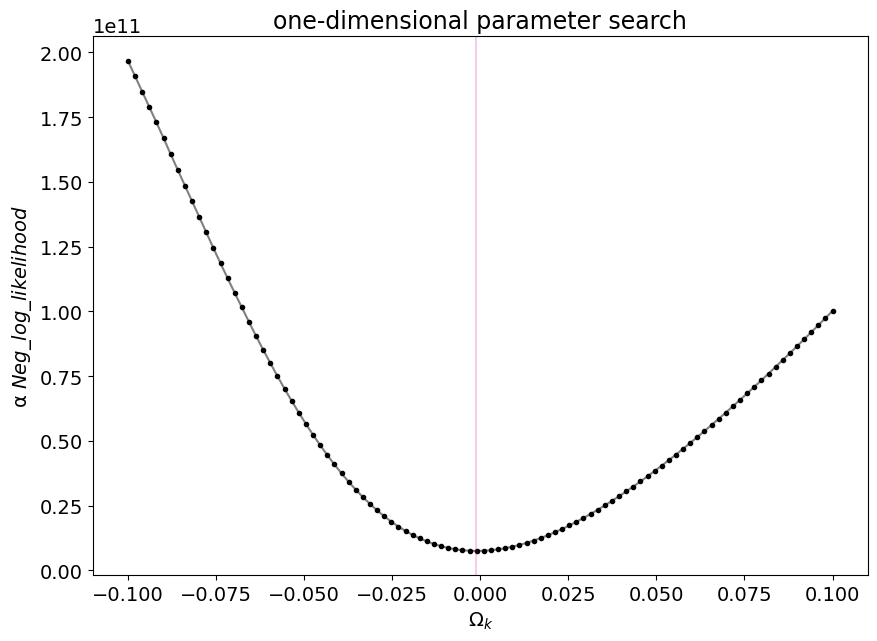

In [87]:
#interpolate
interpolated1 = scipy.interpolate.CubicSpline(data, result)

#visualize one dimensional search
data = np.linspace(-0.1,0.1,100)
plt.plot(data, interpolated1(data), color = 'gray')
plt.plot(data, result, '.', color='k')
plt.axvline(res1.x[0], 0, 2, color='m', alpha=0.2) #result of nelder-mead search
plt.xlabel('$\Omega_k$', fontsize=14)
plt.ylabel('α $Neg\_log\_likelihood$', fontsize=14)
plt.title('one-dimensional parameter search', fontsize=17)
plt.show()

**Neg_log_likelihood 2D search**

In [11]:
#maximum likelihood estimation, varying curvature density and matter density parameter
#by-hand
def neg_log_likelihood2_( x, *args ):
    omegam, omegak = x
    print(omegam, omegak)
    if omegam < 0 or np.isnan(omegam) or np.isnan(omegak):
        return 1e10 
    else:
        h = 0.6766
        Omegab = 0.04897468
        ombh2 = Omegab * h**2
        omch2 = (omegam - Omegab) * h**2
    
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=100*h, ombh2=ombh2, omch2=omch2, omk=omegak, mnu=0.0, tau=0.0561)
        pars.InitPower.set_params(As=np.exp(3.047)/1e10, ns=0.9665, r=0)
    
        results = camb.get_results(pars)
        powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
        total_cls = powers['lensed_scalar']
        theory_cl_tt = total_cls[0:900, 0]
        ell = np.arange(total_cls.shape[0])[0:900]
        observed_cl_tt = clT_masked_lim[0:900]
        variance = 2/((2*ell+1)*sky_fraction)
    
        w_ell = hp.gauss_beam((5*u.arcmin).to_value(u.radian), lmax=899)
        planck = ell,ell*(ell+1)*observed_cl_tt/(2*np.pi) / w_ell**2 / sky_fraction
    
        diff = np.sum((planck[1][2:900] - theory_cl_tt[2:900])**2/variance[2:900])
        print(diff)
    
        return diff

#create a grid, establish range in which to search
omegam_values = np.linspace(0.25, 0.35, 10)
omegak_values = np.linspace(-0.05, 0.05, 10)
likelihood_grid = np.zeros((len(omegam_values), len(omegak_values)))

for i, omegam in enumerate(omegam_values):
    for j, omegak in enumerate(omegak_values):
        likelihood_grid[-1 -i , j] = neg_log_likelihood2_([omegam, omegak])

0.25 -0.05
50926938216.17913
0.25 -0.03888888888888889
38116615080.410866
0.25 -0.02777777777777778
34395712323.73628
0.25 -0.01666666666666667
38368084224.01853
0.25 -0.005555555555555557
48324596422.29695
0.25 0.005555555555555557
62700536448.73342
0.25 0.016666666666666663
80259327429.44409
0.25 0.027777777777777776
100194360546.70724
0.25 0.03888888888888889
122035068336.92918
0.25 0.05
145460438597.57257
0.2611111111111111 -0.05
47211555320.29739
0.2611111111111111 -0.03888888888888889
32120859730.234146
0.2611111111111111 -0.02777777777777778
25409268107.52015
0.2611111111111111 -0.01666666666666667
26082334961.03913
0.2611111111111111 -0.005555555555555557
32698521894.377792
0.2611111111111111 0.005555555555555557
43829702333.26995
0.2611111111111111 0.016666666666666663
58250329241.99122
0.2611111111111111 0.027777777777777776
75113432140.8385
0.2611111111111111 0.03888888888888889
93861242185.61514
0.2611111111111111 0.05
114128962828.1448
0.2722222222222222 -0.05
46278425303.

0.3 0.0
8998624609.164242
0.315 0.0
7410725253.589604
0.3 0.00025
9050636414.084974
0.315 -0.00025
7420633263.533743
0.33 -0.00025
9606932627.973213
0.3075 -6.25e-05
7686043999.810986
0.3225 -0.0001875
8089242934.699496
0.31125 -9.375e-05
7423269464.337038
0.31875 -0.00015625
7639305718.828101
0.313125 -0.000109375
7388721836.773495
0.31312500000000004 0.00014062500000000002
7383691101.7221
0.31218750000000006 0.0003359375
7398012392.069208
0.31124999999999997 3.1250000000000014e-05
7423867130.078466
0.3140625 7.812500000000004e-06
7389076153.445493
0.31218749999999995 2.343750000000001e-05
7397491617.639799
0.31359375 1.1718750000000005e-05
7385505058.285042
0.31359375 0.00026171875
7380111127.794123
0.313828125 0.00044726562500000007
7377060476.366665
0.313359375 0.0005761718750000001
7377914439.2013855
0.31406249999999997 0.0008828125
7372607697.460459
0.31453124999999993 0.00125390625
7371099149.673496
0.31499999999999995 0.001125
7374236230.759321
0.31570312499999986 0.00193164062

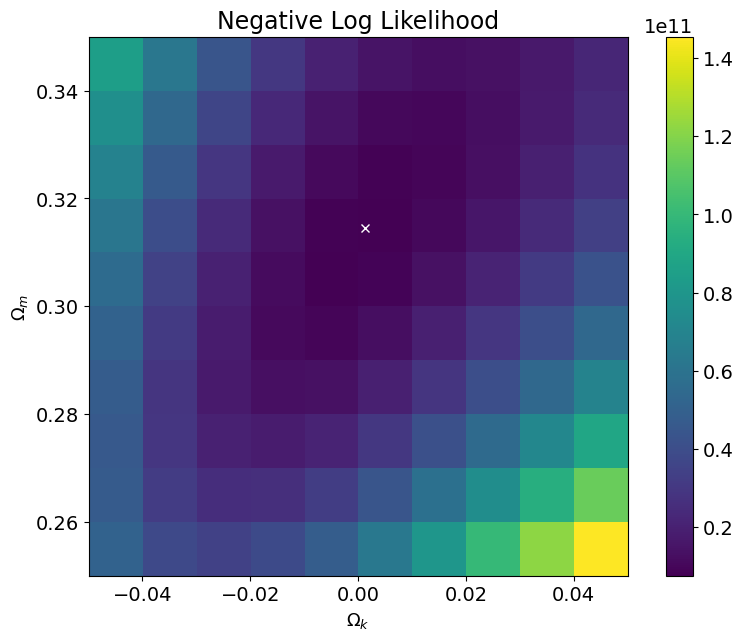

In [12]:
#maximum likelihood estimation using scipy
res = scipy.optimize.minimize( neg_log_likelihood2_, [0.3, 0.0], options={'maxiter': 100}, method = 'Nelder-Mead')

plt.imshow(likelihood_grid, extent=[omegak_values.min(), omegak_values.max(), omegam_values.min(), omegam_values.max()])
plt.plot( res.x[1], res.x[0], 'x', color='white' )                                                                          
plt.colorbar()
plt.xlabel(r'$\Omega_k$', fontsize=13)
plt.ylabel(r'$\Omega_m$', fontsize=13)
plt.title('Negative Log Likelihood', fontsize=17)
plt.show()

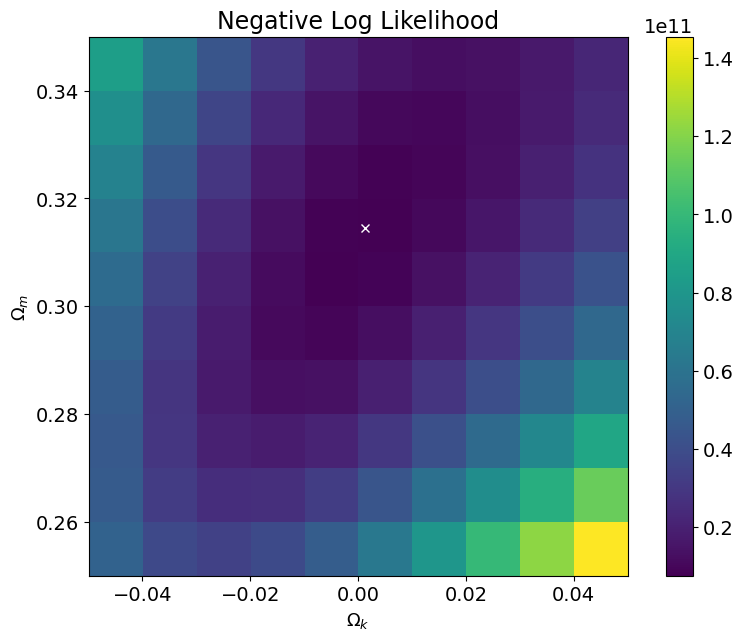

In [13]:
#display results
plt.imshow(likelihood_grid, extent=[omegak_values.min(), omegak_values.max(), omegam_values.min(), omegam_values.max()]) 
plt.plot( res.x[1], res.x[0], 'x', color='white' ) 
plt.colorbar()
plt.xlabel(r'$\Omega_k$', fontsize=13)
plt.ylabel(r'$\Omega_m$', fontsize=13)
plt.title('Negative Log Likelihood', fontsize=17)
plt.show()

In [14]:
print(res.x[1], res.x[0])

0.0012677875663050424 0.31454390525878273


0.312 0.0
7404074399.747441
0.312 0.00044444444444444447
7404359440.742153
0.312 0.0008888888888888889
7413453746.123194
0.312 0.0013333333333333335
7428804759.628244
0.312 0.0017777777777777779
7450397600.730459
0.312 0.0022222222222222222
7478246809.535479
0.312 0.002666666666666667
7512510151.539618
0.312 0.0031111111111111114
7553080202.651781
0.312 0.0035555555555555557
7599886708.771591
0.312 0.004
7652877946.044683
0.31244444444444447 0.0
7395435574.733594
0.31244444444444447 0.00044444444444444447
7392470618.744276
0.31244444444444447 0.0008888888888888889
7398466905.146904
0.31244444444444447 0.0013333333333333335
7410736146.840073
0.31244444444444447 0.0017777777777777779
7429250924.36347
0.31244444444444447 0.0022222222222222222
7454006798.023333
0.31244444444444447 0.002666666666666667
7485194262.339216
0.31244444444444447 0.0031111111111111114
7522686186.313951
0.31244444444444447 0.0035555555555555557
7566422973.253495
0.31244444444444447 0.004
7616314890.701088
0.3128888

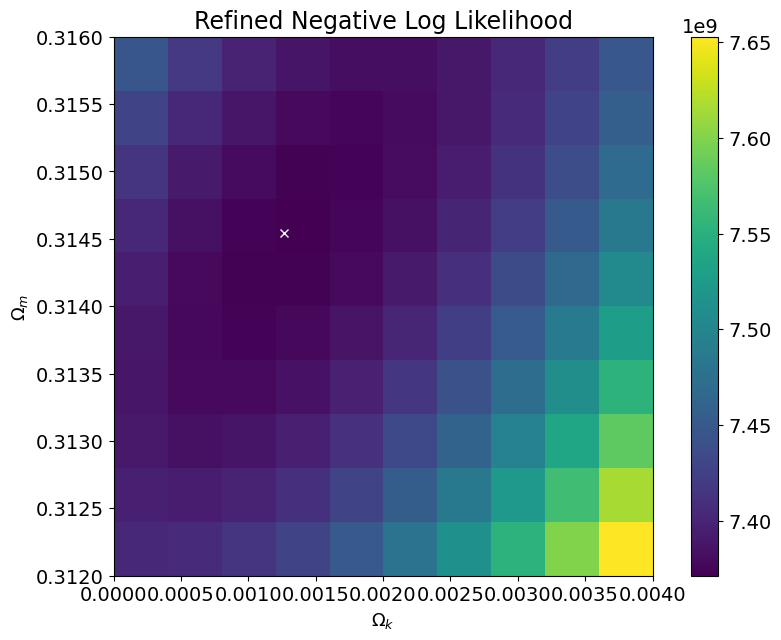

In [16]:
#refined parameter intervals (does not change the result, only the grid search)
omegam_values = np.linspace(0.312, 0.316, 10)
omegak_values = np.linspace(-0.00, 0.004, 10)
likelihood_grid = np.zeros((len(omegam_values), len(omegak_values)))

for i, omegam in enumerate(omegam_values):
    for j, omegak in enumerate(omegak_values):
        likelihood_grid[-1 -i , j] = neg_log_likelihood2_([omegam, omegak])

plt.imshow(likelihood_grid, extent=[omegak_values.min(), omegak_values.max(), omegam_values.min(), omegam_values.max()]) 
plt.plot( res.x[1], res.x[0], 'x', color='white' ) 
plt.colorbar()
plt.xlabel(r'$\Omega_k$', fontsize=13)
plt.ylabel(r'$\Omega_m$', fontsize=13)
plt.title('Refined Negative Log Likelihood', fontsize=17)
plt.show()